# MSc in AI - CE6002 & CS5062


# E-tivity 5: Higher Dimensions

# CE6002 - Tasks 4 and 5

## Student Name: Mark Murnane
## Student ID: 18195326
-----

You may add two extra libraries: one to make a train-test split and one to perform a grid search

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

Sample code to plot SVM margin, 'gutters' and support vectors

MM: Converted to a function

In [2]:
plt.rcParams["figure.figsize"] = (9,9)


def plot_dataset(features, target, title=None):
    plt.scatter(features[:, 0], features[:, 1], c=target, s=30, cmap=plt.cm.Paired)
    
    plt.title(title)
    plt.show()


def plot_svm_margins(features, target, classifier):

    plt.scatter(features[:, 0], features[:, 1], c=target, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = classifier.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    ax.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    
    # Title
    plt.title(f"SVM with C={classifier.C}")

    


# Task 4

------

### Import Dataset 1

The datafile *dataset_1.csv* contains the data for Task 4 containing 10,001 samples.  The first line of the file appears to be aheader.  The first column of the file appears to be a simple row reference (zero-based).  Both of these elements can omitted from the file.

Each row of the file then contains two attributes (floating point numbers) and a target which is either 1 or 0.  

To keep the number of imports low we can use Numpy routines to import the data, such as `genfromtxt`.

In [3]:
# Read the data and drop the header and the first column
all_data = np.genfromtxt('./dataset_1.csv', delimiter=',', skip_header=1, usecols=(1, 2, 3))

# Split the data into the features and target
X = all_data[:,:-1]
y = all_data[:,-1]

Before doing anything else separate the data set into a Training and Test set. Given the large data set it's safe to take the usual 20% of data for test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

For the purpose of this exercise, visualise the data set to see what type of problem it is.

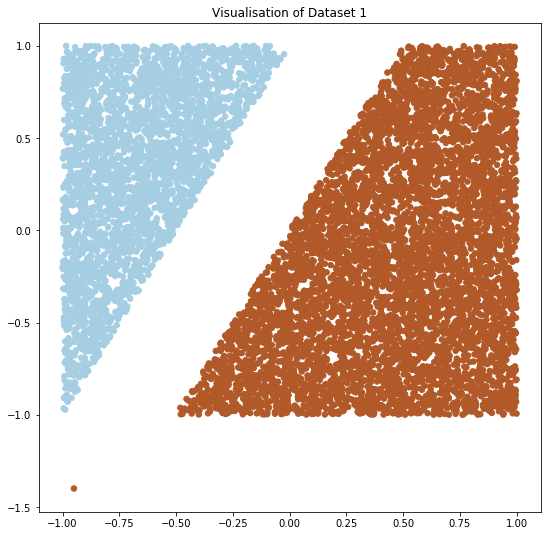

In [5]:
plot_dataset(X, y, "Visualisation of Dataset 1")

The outlier will be important feature for this task.

### Baseline

As a baseline an SVM classifier with _linear_ kernel with default options is used.

In [6]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Training score of SVC with all defaults: 1.0
Test score of SVC with all defaults: 1.0


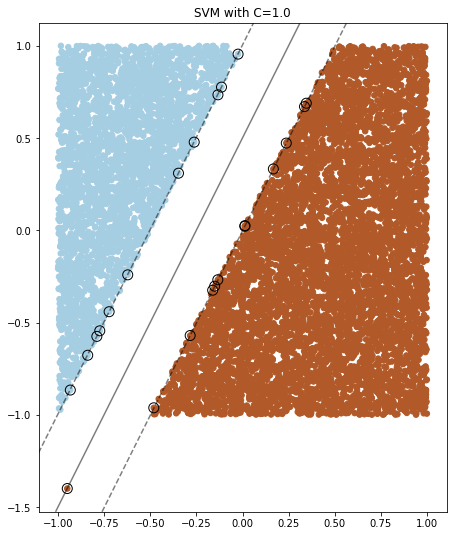

In [7]:
print(f"Training score of SVC with all defaults: {clf.score(X_train, y_train)}")
print(f"Test score of SVC with all defaults: {clf.score(X_test, y_test)}")
plot_svm_margins(X, y, clf)

For the baseline settings we can determine how "good" the model is by evaluating the expected value of $E_{out}$.

In [8]:
def calc_svm_eout(data, svm_clf):
    num_samples = data.shape[0]
    num_svectors = np.sum(svm_clf.n_support_)
    
    return (num_svectors)/(num_samples - 1)

In [9]:
print(f"The number of support vectors is: {np.sum(clf.n_support_)}")
print(f"The expected value of Eout is <= {calc_svm_eout(X_train, clf)}")
print(f"The margin is: {1/np.linalg.norm(clf.coef_)}")

The number of support vectors is: 23
The expected value of Eout is <= 0.002875359419927491
The margin is: 0.22533656183276415


### Hard and Soft margin C values

In general, high values of C represent hard margins, and low values of C represent soft margins.  A soft margin may even allow misclassification in a completely separable data set.

For the hard margin, the widest practical margin will be the one with the smallest number of support vectors.

For a soft margin, the acceptable margin will be domain specific; it depends on what value of $\mathbb{E}[E_{out}]$ is acceptable.

For now we'll try a range of values for C to examine the number of support vectors, the margin and the expected value of $E_{out}$.

In [10]:
INTERVALS=9

c_values = np.geomspace(0.0001, 10000, num=INTERVALS)

scores = np.zeros(INTERVALS)
s_vectors = np.zeros(INTERVALS, dtype=int)
margins = np.zeros(INTERVALS)
e_outs = np.zeros(INTERVALS)

for i, c_val in enumerate(c_values):
    loop_svm = svm.SVC(kernel='linear', C=c_val)
    loop_svm.fit(X_train, y_train)
    
    scores[i] = loop_svm.score(X_test, y_test)
    s_vectors[i] = np.sum(loop_svm.n_support_)
    margins[i] = 1/np.linalg.norm(loop_svm.coef_)
    e_outs[i] = calc_svm_eout(X_train, loop_svm)    

In [11]:
print(f"Scores:\n{scores}\n")
print(f"Support Vectors:\n{s_vectors}\n")
print(f"Margins:\n{margins}\n")
print(f"E_out:\n{e_outs}\n")


Scores:
[0.65617191 1.         1.         1.         1.         1.
 1.         1.         1.        ]

Support Vectors:
[5260 3988 1137  182   23    5    3    3    3]

Margins:
[3.94612609 0.61296608 0.32259781 0.24070136 0.22533656 0.2238621
 0.13151102 0.13151102 0.13151102]

E_out:
[6.57582198e-01 4.98562320e-01 1.42142768e-01 2.27528441e-02
 2.87535942e-03 6.25078135e-04 3.75046881e-04 3.75046881e-04
 3.75046881e-04]



The best way to analyse these results is to visualise them.

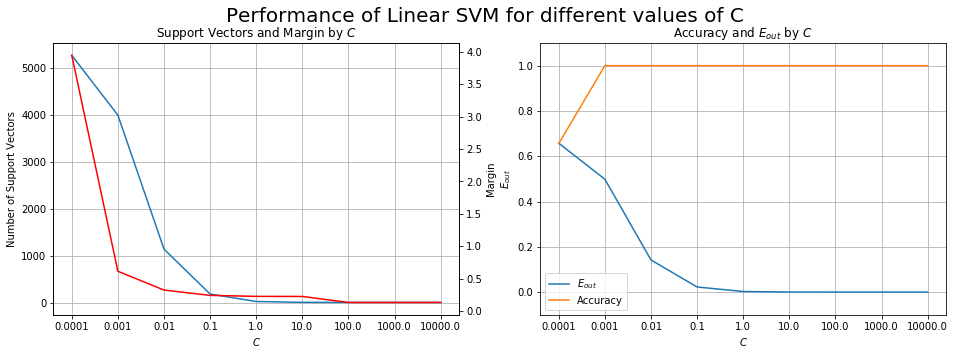

In [12]:
# Create a wide figure
fig = plt.figure(figsize=(16,5))
fig.suptitle("Performance of Linear SVM for different values of C", fontsize=20)

# Plot the number of support vectors and the margin
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.log10(c_values), s_vectors, label="Support Vectors")

# Margin is on a different scale
ax_mar = ax.twinx()
ax_mar.plot(np.log10(c_values), margins, 'r', label="Margin")
ax_mar.set_ylabel("Margin")

ax.grid(True)
ax.set_title("Support Vectors and Margin by $C$")
ax.set_xlabel("$C$")
ax.set_xticklabels(np.insert(c_values, 0, 0))
ax.set_ylabel("Number of Support Vectors")




# Plot the values of 
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.log10(c_values), e_outs, label="$E_{out}$")
ax.plot(np.log10(c_values), scores, label="Accuracy")
ax.grid(True)

ax.set_title("Accuracy and $E_{out}$ by $C$")
ax.set_xlabel("$C$")
ax.set_xticklabels(np.insert(c_values, 0, 0))
ax.set_ylabel("$E_{out}$")
ax.set_ylim(-0.1,1.1)
ax.legend()

plt.show()

From these graphs we can see that the the score of the classifiers reach 1 very early on, with a $C$ value of 0.001.  

For the hard margin, the widest practical point would be where the margin reaches it's minimum.  Where the margin is minimised and the support vectors are minimised represents the widest margin.  Any value of $C$ beyond that doesn't produce a wider margin.

In the plots we can see that the margin is minimial from $C$ > 1, and the number of support vectors is minimised at $C=100$.

In [13]:
print(f"The margins from C>=1 are: {margins[4:,]}")
print(f"The number of support vectors from C>=1 are: {s_vectors[4:,]}")

The margins from C>=1 are: [0.22533656 0.2238621  0.13151102 0.13151102 0.13151102]
The number of support vectors from C>=1 are: [23  5  3  3  3]


From this we can see that margin and number of support vectors doesn't improve beyond $C=100$.  This is the widest value for a hard margin.

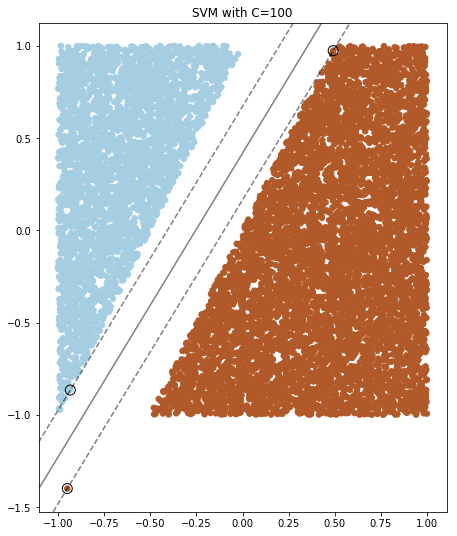

In [14]:
hard_clf = svm.SVC(C=100, kernel='linear')
hard_clf.fit(X_train, y_train)
plot_svm_margins(X, y, hard_clf)

In this case the support vectors are _margin_ support vectors.

------

For a soft margin, the defining feature is that *some* values can be misclassified.  The soft margin can be as wide as our domain allows.

Using the plot above, the expected value of $E_{out}$ flattens from $C=1$ so a value less than this is an example of a soft margin. For plotting purposes, a value of $C=0.01$ better shows misclassification of the outlier.

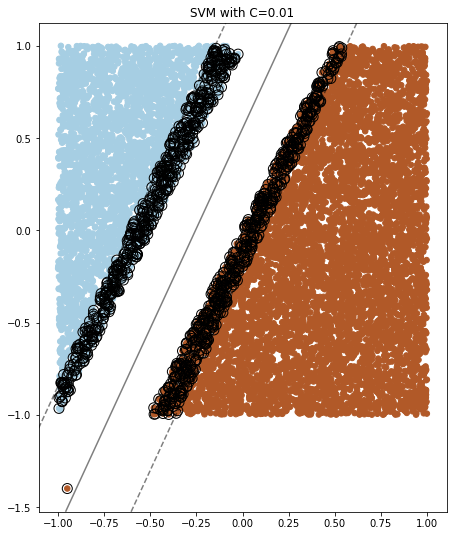

In [15]:
soft_clf = svm.SVC(C=0.01, kernel='linear')
soft_clf.fit(X_train, y_train)
plot_svm_margins(X, y, soft_clf)

Here the support vectors are *non-margin* support vectors.

### Conclusion

All models successfully separate the data in the test set. The baseline implementation, as expected separates the data at exactly the midpoint between the two classes, even though there is a single outlier right on this line.

The classifier with a soft margin draws a different separating line, resulting in the misclassification of this outlier.  It has quite a wide margin allowing for some misclassification to occur while maintaining confidence in the algorithm.  In this contrived example the very low value of C means that soft margin covers quite a bit of the different classes.

The classifier with the hard margin correctly classifies all results, but has a relatively narrow margin for this.  It has fewer support vectors, and the line of separation visually appears to sub-optimal.

-------


# Task 5

Exploration of datasets using Support Vector Machines

### Dataset 1


Perform a Grid Search of different parameters for this data set.

Based on the earlier work in Task 4, the value of C is confined more to ease the computation.
Even though this is a linear set, the Radial Basis Function and Polynomial kernels are attempted.

For dataset 1 we have see what a linear model can do, so in this case we'll confine the search to what an RBF or Polynomial kernel can do.

A value for gamma is included to get a sense of how (or if) this plays a part in bias/variance trade off for this data set.


In [16]:
%%time
# Dictionary of parameters to be assessed as part of GridSearch
param_grid = [
    {'C': np.logspace(-3, 3, 7), 
     'kernel': ['rbf', 'poly']
     ,'gamma': [0.01, 0.1, 1, 10, 'auto' ]
     ,'degree': [3, 5]
    }
]

# Create a GridSearch over SVC optimising for Recall using 5 folds as with the original evaluations
ds1_grid = GridSearchCV(estimator=svm.SVC(),
                   param_grid=param_grid,
                   scoring='accuracy',
                   cv=5,
                   n_jobs=-2, refit=True, verbose=1)

# Apply fit to execute the search
ds1_grid.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 687 out of 700 | elapsed:  1.9min remaining:    2.1s
[Parallel(n_jobs=-2)]: Done 700 out of 700 | elapsed:  2.5min finished


Wall time: 2min 31s


In [17]:
ds1_grid.best_estimator_

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
ds1_svm = ds1_grid.best_estimator_
ds1_svm.score(X_test, y_test)

1.0

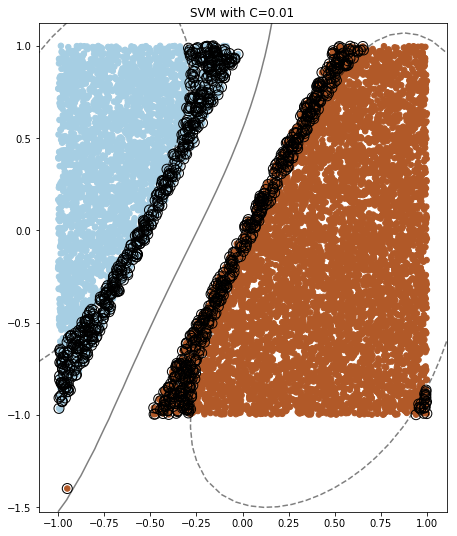

In [19]:
plot_svm_margins(X, y, ds1_svm)

In [20]:
print(f"The number of support vectors is: {np.sum(ds1_svm.n_support_)}")
print(f"The expected value of Eout is <= {calc_svm_eout(X_train, ds1_svm)}")

The number of support vectors is: 1152
The expected value of Eout is <= 0.14401800225028127


Interestingly the GridSearch chose a soft margin with a large number of support vectors that is unnecessarily complex.  A simpler model with a large C would work better.

D:\Masters\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


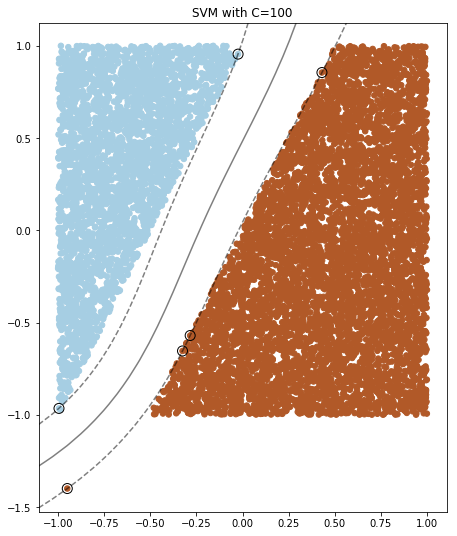

In [21]:
ds1_rbf_svm = svm.SVC(kernel='rbf', C=100)
ds1_rbf_svm.fit(X_train, y_train)
plot_svm_margins(X, y, ds1_rbf_svm)

In [22]:
ds1_rbf_svm

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

The hyperplane here is an interesting variation, but is more complex (with 3 extra support vectors) than the linear model.

In [23]:
print(f"The number of support vectors is: {np.sum(ds1_rbf_svm.n_support_)}")
print(f"The expected value of Eout is <= {calc_svm_eout(X_train, ds1_rbf_svm)}")

The number of support vectors is: 6
The expected value of Eout is <= 0.0007500937617202151


This model has a significantly better value for $E_{out}$ then the Grid Search equivalent.  The danger perhaps here is in the combination of parameters that grid search used.

### Dataset 2

The datafile *dataset_2.csv* contains 10,000 samples.  As before the first line of the file appears to be a header and the first column is a simple counter.  Both of these elements will be omitted from the imported data.

Each row of the file then contains two attributes (floating point numbers) and a target which is either 1 or 0.

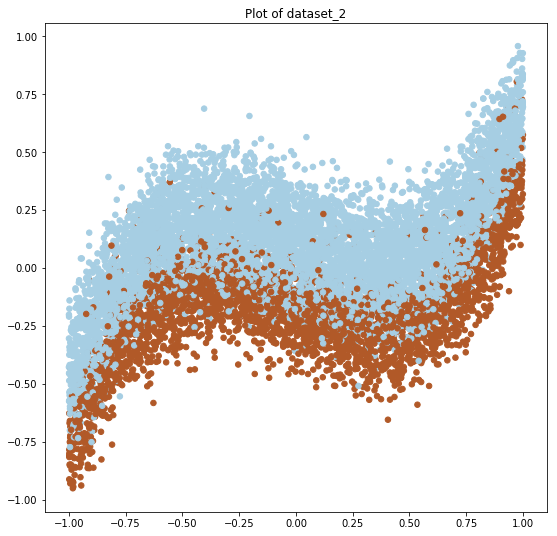

In [44]:
# Read the data and drop the header and the first column
all_dataset_2 = np.genfromtxt('./dataset_2.csv', delimiter=',', skip_header=1, usecols=(1, 2, 3))

# Split the data into the features and target
X_ds2 = all_dataset_2[:,:-1]
y_ds2 = all_dataset_2[:,-1]

plot_dataset(X_ds2, y_ds2, 'Plot of dataset_2')

In [45]:
X_ds2_train, X_ds2_test, y_ds2_train, y_ds2_test = train_test_split(X_ds2, y_ds2, test_size=0.2, shuffle=True, random_state=42)

We can see from the dataset that a linear model will not work in this case.  For that reason the Grid Search doesn't include the linear kernel.

For this Grid Search, the polynomial degrees are chosen as candidates that might match the apparent target function.

In [58]:
%%time
# Dictionary of parameters to be assessed as part of GridSearch
param_grid = [
    {'C': np.logspace(-3, 3, 7), 
     #'kernel': ['rbf']
     'kernel': ['rbf', 'poly']
     #,'gamma': [0.01, 0.1, 1, 10, 'auto' ]
     ,'degree': [3, 4]
    }
]

# Create a GridSearch over SVC optimising for Recall using 5 folds as with the original evaluations
ds2_grid = GridSearchCV(estimator=svm.SVC(),
                   param_grid=param_grid,
                   scoring='accuracy',
                   cv=10,
                   n_jobs=-2, refit=True, verbose=1)

# Apply fit to execute the search
ds2_grid.fit(X_ds2_train, y_ds2_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-2)]: Done 280 out of 280 | elapsed:  1.7min finished
D:\Masters\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 1min 44s


In [59]:
ds2_grid.best_estimator_

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [60]:
ds2_svm = ds2_grid.best_estimator_
ds2_svm.score(X_ds2_test, y_ds2_test)

0.8575

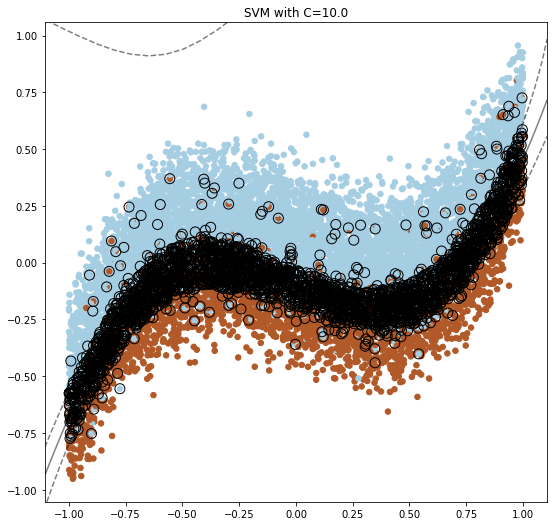

In [61]:
plot_svm_margins(X_ds2, y_ds2, ds2_svm)

In [62]:
print(f"The number of support vectors is: {np.sum(ds2_svm.n_support_)}")
print(f"The expected value of Eout is <= {calc_svm_eout(X_ds2_train, ds2_svm)}")

The number of support vectors is: 2738
The expected value of Eout is <= 0.3422927865983248


The high value of $E_{out}$ and the high number of support vector suggest this is a poor model.  One option is to increase the value of C to close the margin further. 

D:\Masters\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The score for this alternative (C=100) is: 0.859


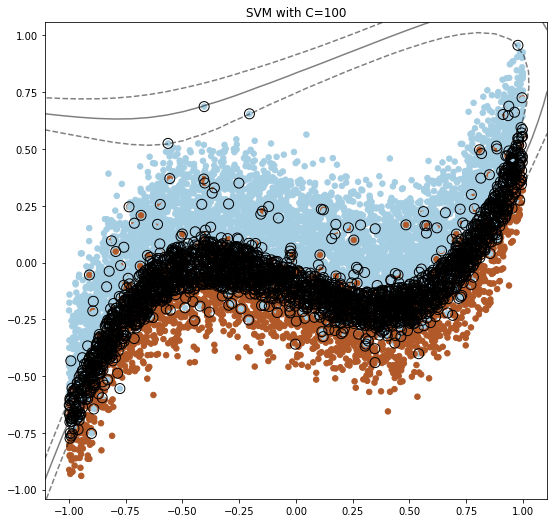

In [69]:
rbf_clf = svm.SVC(C=100, kernel='rbf')
rbf_clf.fit(X_ds2_train, y_ds2_train)
print(f"The score for this alternative (C=100) is: {rbf_clf.score(X_ds2_test, y_ds2_test)}")
plot_svm_margins(X_ds2_train, y_ds2_train, rbf_clf)

In [68]:
print(f"The number of support vectors is: {np.sum(rbf_clf.n_support_)}")
print(f"The expected value of Eout is <= {calc_svm_eout(X_ds3_train, rbf_clf)}")

The number of support vectors is: 2623
The expected value of Eout is <= 0.32791598949868733


In this adapted model we end up with a slight improvement in accuracy, $E_{out} and the number of support vectors but the plot suggests a more complex curve.  This margin boundaries suggest something that might not generalise well.

### Dataset 3

The datafile *dataset_3.csv* also contains 10,000 samples.  As before the first line of the file appears to be a header and the first column is a simple counter.  Both of these elements will be omitted from the imported data.

Each row of the file then contains two attributes (floating point numbers) and a target which is either 1 or 0.

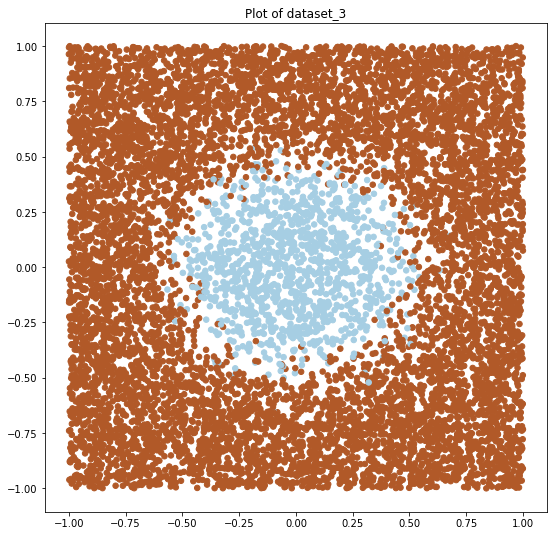

In [16]:
# Read the data and drop the header and the first column
all_dataset_3 = np.genfromtxt('./dataset_3.csv', delimiter=',', skip_header=1, usecols=(1, 2, 3))

# Split the data into the features and target
X_ds3 = all_dataset_3[:,:-1]
y_ds3 = all_dataset_3[:,-1]

plot_dataset(X_ds3, y_ds3, 'Plot of dataset_3')

In [17]:
X_ds3_train, X_ds3_test, y_ds3_train, y_ds3_test = train_test_split(X_ds3, y_ds3, test_size=0.2, shuffle=True, random_state=42)

As before the linear kernel is omitted as the data set is not linearly separable.

Also, while technically data snooping, for the purposes of the exercise, the polynomial is reduced to something better suited to a circular/elliptical hyperplane.

When running this estimator, I found that setting scoring to _accuracy_ did not yield good results.  Precision was a better metric for evaluation.


In [30]:
%%time
# Dictionary of parameters to be assessed as part of GridSearch

param_grid = [
    {'C': np.logspace(-3, 3, 7), 
     'kernel': ['rbf']
     #'kernel': ['rbf', 'poly']
     #,'gamma': [0.01, 0.1, 1, 10, 'auto' ]
     #,'degree': [2, 3]
    }
]

# Create a GridSearch over SVC optimising for Recall using 5 folds as with the original evaluations
ds3_grid = GridSearchCV(estimator=svm.SVC(),
                   param_grid=param_grid,
                   scoring='precision',
                   cv=10,
                   n_jobs=-2, refit=True, verbose=1)

# Apply fit to execute the search
ds3_grid.fit(X_ds3_train, y_ds3_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.6s


Wall time: 4.76 s


[Parallel(n_jobs=-2)]: Done  70 out of  70 | elapsed:    4.6s finished
D:\Masters\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [32]:
ds3_grid.best_estimator_

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [35]:
ds3_svm = ds3_grid.best_estimator_
ds3_svm.score(X_ds3_test, y_ds3_test)

0.9885

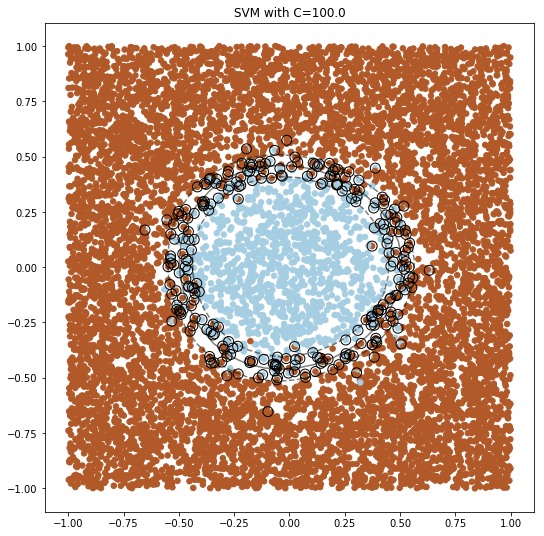

In [36]:
plot_svm_margins(X_ds3, y_ds3, ds3_svm)

In [37]:
print(f"The number of support vectors is: {np.sum(ds3_svm.n_support_)}")
print(f"The expected value of Eout is <= {calc_svm_eout(X_ds3_train, ds3_svm)}")

The number of support vectors is: 265
The expected value of Eout is <= 0.03312914114264283


In this example by confining the search to just $C$ values a good separation was found.

-------

### Conclusion

It was interesting to note that the GridSearchCV did not always find an optimal result.  It's notable that for the first 2 datasets the Polynomial kernel wasn't selected.  This perhaps reinforces Dr. Ng's view that the polynomial kernel is not common.

As a final note, the tests and results here were restricted to due an unexplained increase in the runtimes for the GridSearch. This resulted in the search parameters being confined.  I'm unclear why, but the data set (not the data volume) seems to have had a significant impact.  The GridSearch for dataset1 is more complex on the same sample size, but the other searches had to be interrupted as they were not concluding.

## Pictures for Post

In [38]:
random_indices = np.random.choice(X.shape[0], 15, replace=False)
print(random_indices)

[8371  872 4899 3432 4432 5880 2295 8446 8319 6409 3409 4171 5634 9756
 2644]


In [39]:
x_random = X[random_indices]
y_random = y[random_indices]
print(x_random)
print(y_random)

[[-0.48888657  0.46936671]
 [-0.99151974  0.15251181]
 [ 0.62116572 -0.86368601]
 [ 0.38003277  0.28957999]
 [ 0.97088463 -0.82992916]
 [ 0.49118211  0.75852366]
 [ 0.0220649  -0.86246832]
 [-0.79342048  0.68263271]
 [ 0.2898083   0.30901277]
 [-0.55105318  0.75919936]
 [-0.75321456  0.31262284]
 [ 0.55429624 -0.80363743]
 [-0.22397768  0.66393921]
 [ 0.72200361  0.65195534]
 [ 0.88684772 -0.60501189]]
[0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.]


Text(0.5,1,'15 Data points from 2 classes')

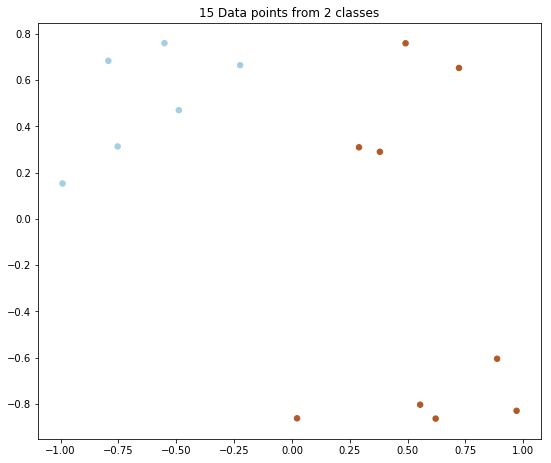

In [40]:
plt.scatter(x_random[:, 0], x_random[:, 1], c=y_random, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
ax.set_aspect(aspect=1)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

plt.title("15 Data points from 2 classes")

In [51]:
clf = svm.SVC(C=10, kernel='linear')
clf.fit(x_random, y_random)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

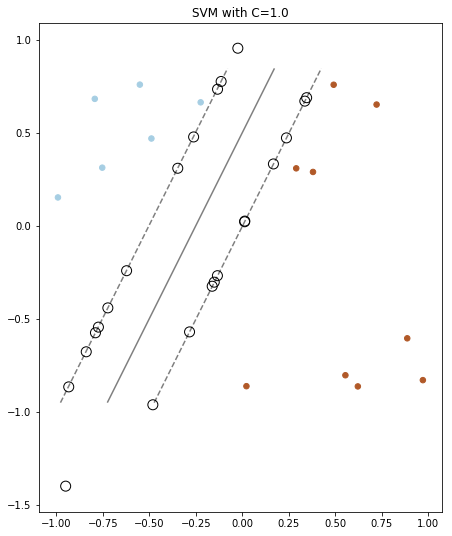

In [41]:
plot_svm_margins(x_random, y_random, clf)

D:\Masters\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


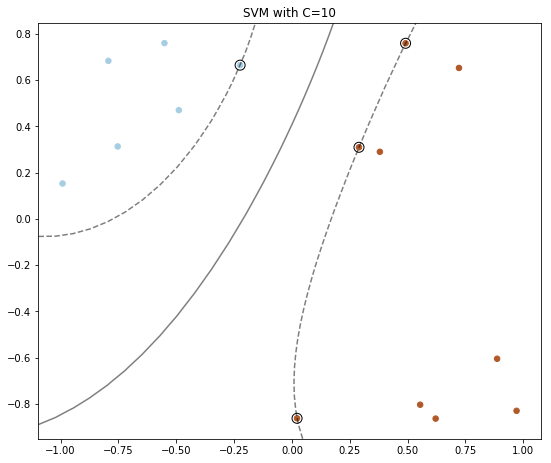

In [42]:
r2_clf = svm.SVC(C=10, kernel='rbf')
r2_clf.fit(x_random, y_random)
plot_svm_margins(x_random, y_random, r2_clf)